# Thompson sampling basic

## Multi-armed Bandit Problem

The Multi-Armed Bandit problem is the simplest setting of reinforcement learning. Suppose that a gambler faces a row of slot machines (bandits) on a casino. Each one of the $K$ machines has a probability $\theta_{k}$ of providing a reward to the player. Thus, the player has to decide which machines to play, how many times to play each machine and in which order to play them, in order to maximize his long-term cumulative reward. 

And the book "[Bandit Algorithms](https://tor-lattimore.com/downloads/book/book.pdf)"

In [1]:
# plotting inline
%matplotlib inline

# working directory
#import os; os.chdir('/home/gdmarmerola/ts_demo')

# importing necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta as beta_dist
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

# turning off automatic plot showing, and setting style
plt.ioff()
plt.style.use('fivethirtyeight')

In [2]:
# class for our row of bandits
class MAB:
    
    # initialization
    def __init__(self, bandit_probs):
        
        # storing bandit probs
        self.bandit_probs = bandit_probs
        
    # function that helps us draw from the bandits
    def draw(self, k):

        # we return the reward and the regret of the action
        # n=1 trials and self.bandit_probs[k] probability of success 
        return np.random.binomial(1, self.bandit_probs[k]), np.max(self.bandit_probs) - self.bandit_probs[k]

In [3]:
# defining a set of bandits with known probabilites
bandit_probs = [0.35, 0.40, 0.30, 0.25]
# instance of our MAB class
mab = MAB(bandit_probs)

In [4]:
# number of draws
N_DRAWS = 500

# number of bandits
N_BANDITS = len(mab.bandit_probs)

# numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
k_array = np.zeros((N_BANDITS,N_DRAWS))
reward_array = np.zeros((N_BANDITS,N_DRAWS))

# lists for ease of use, visualization
k_list = []
reward_list = []

# opening figure and setting style
fig, ax = plt.subplots(figsize=(9, 3), dpi=150)
ax.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))

# colors for each bandit
bandit_colors = ['red', 'green', 'blue', 'purple']

# loop generating draws
for draw_number in range(N_DRAWS):
    
    # choosing arm and drawing
    k = np.random.choice(range(N_BANDITS),1)[0]
    reward, regret = mab.draw(k)
    
    # record information about this draw
    k_list.append(k)
    reward_list.append(reward)
    k_array[k, draw_number] = 1
    reward_array[k, draw_number] = reward
      
    # getting list of colors that tells us the bandit
    color_list = [bandit_colors[k] for k in k_list]
    
    # getting list of facecolors that tells us the reward
    facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]    
    
# initializing with first data
scatter = ax.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);

# titles
plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10)
ax.set_yticks([0,1,2,3])
ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
ax.tick_params(labelsize=10)
fig.tight_layout()

# function for updating
def animate(i):
    x = list(range(N_DRAWS))[:i]
    y = k_list[:i]
    scatter.set_offsets(np.c_[x, y])
    scatter.set_color(color_list[:i])
    scatter.set_facecolor(facecolor_list[:i])
    ax.set_yticks([0,1,2,3])
    ax.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
    ax.tick_params(labelsize=10)
    return (scatter,)

# function for creating animation
anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=25, blit=True)

# showing
HTML(anim.to_html5_video())

## Estimating Reward Probabilities

First, we need a **prior** distribution, i.e., a distribution for the probabilities (the $\theta_k$'s of the bandits. As each of our 
$K$ bandits is a bernoulli random variable with sucess probability $\theta_k$, our prior distribution over $\theta_k$ comes naturally: the **Beta distribution**!

The Beta distribution, $Beta(1+\alpha, 1+\beta)$, models the parameter of a bernoulli random variable after we've obserbed $\alpha$ sucesses and $\beta$ failures. Let's view some examples!

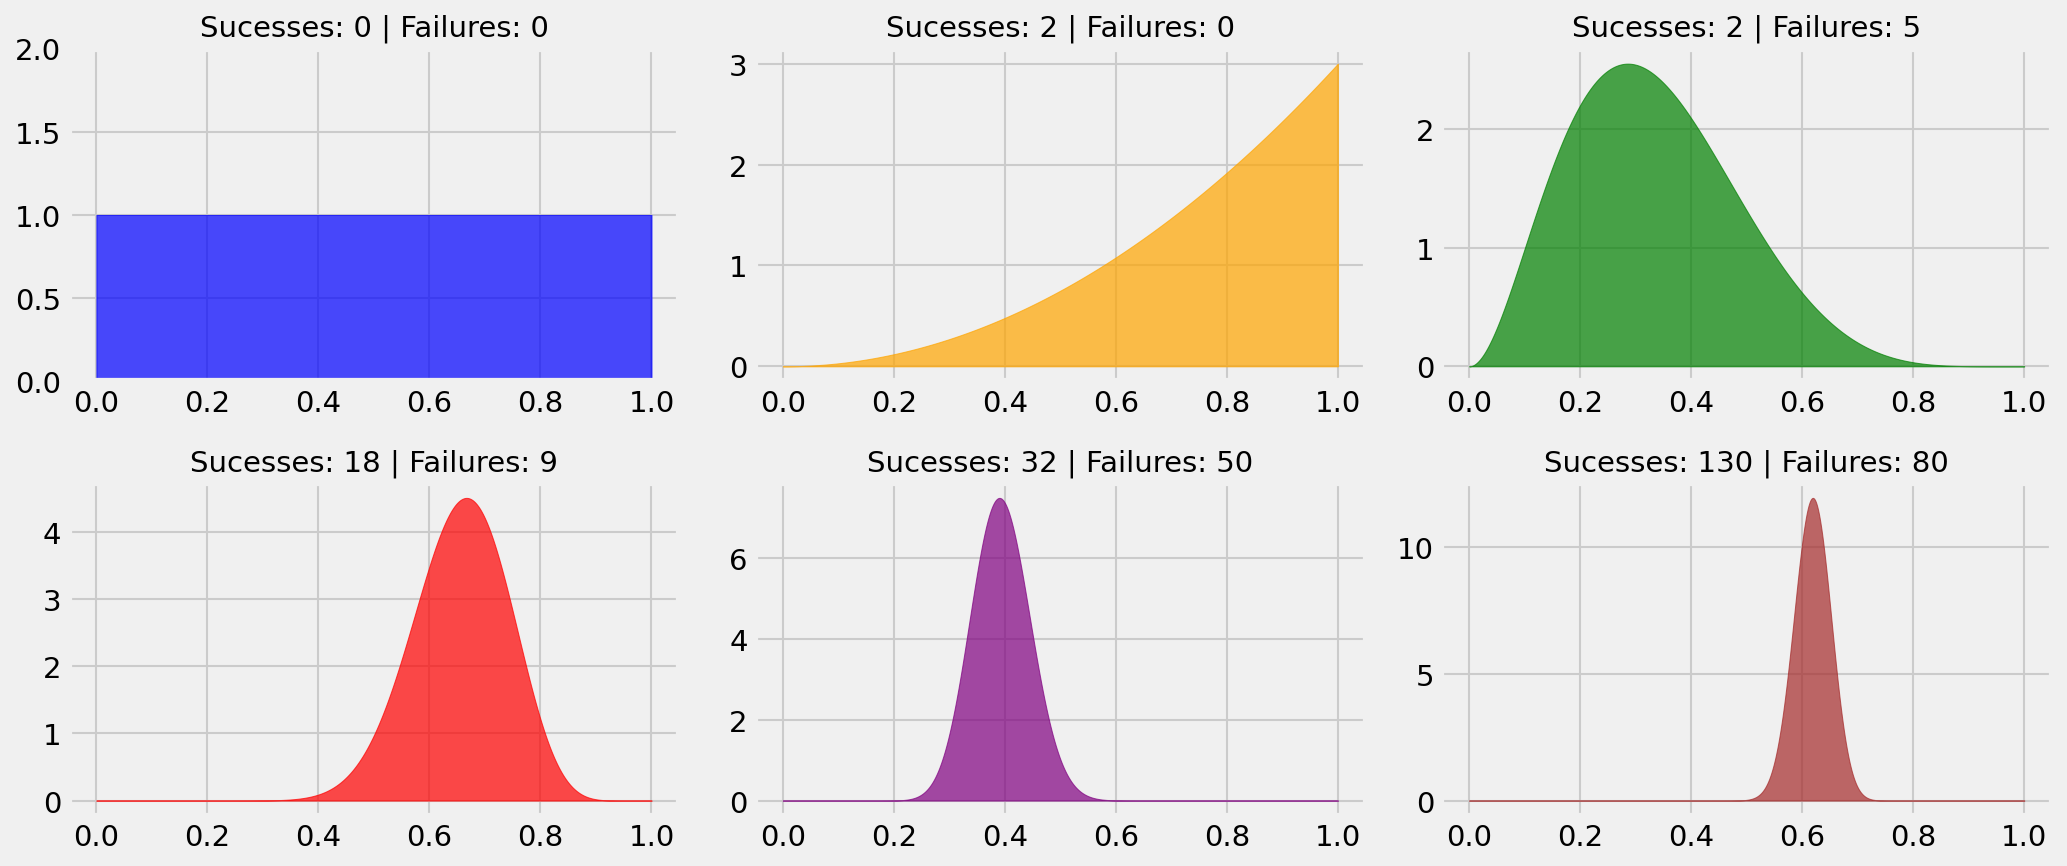

In [5]:
# clearing past figures
plt.close('all')

# examples 
beta_examples = [(0,0),(2,0),(2,5),(18,9),(32,50),(130,80)]

# colors for the plots
beta_colors = ['blue','orange','green','red','purple','brown']

# opening figure
fig, ax = plt.subplots(figsize=(14, 6), dpi=150, nrows=2, ncols=3)

# loop for each 
for i, example in enumerate(beta_examples):
    
    # points to sample for drawing the curve
    X = np.linspace(0,1,1000)
    
    # generating the curve
    dist = beta_dist(1 + example[0],1 + example[1])
    curve = dist.pdf(X)
    
    # plotly data
    ax[int(i/3)][(i % 3)].fill_between(X, 0, curve, color=beta_colors[i], alpha=0.7)
    ax[int(i/3)][(i % 3)].set_title('Sucesses: {} | Failures: {}'.format(example[0],example[1]), fontsize=14)

# some adjustments
ax[0][0].set(ylim=[0,2])
plt.tight_layout()
#plt.

# showing the figure
plt.show()

## Completed random strategy

In [11]:
# let us create a function that returns the pdf for our beta posteriors
def get_beta_pdf(alpha, beta):
    X = np.linspace(0,1,1000)
    return X, beta_dist(1 + alpha,1 + beta).pdf(X)

# for now, let us perform random draws
def random_policy(k_array, reward_array, n_bandits):
    return np.random.choice(range(n_bandits),1)[0]

In [7]:
# let us wrap a function that draws the draws and distributions of the bandit experiment
def plot_MAB_experiment(decision_policy, N_DRAWS, bandit_probs, plot_title):

    # clearing past figures
    plt.close('all')

    # number of bandits
    N_BANDITS = len(bandit_probs)
    
    # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
    k_array = np.zeros((N_BANDITS,N_DRAWS))
    reward_array = np.zeros((N_BANDITS,N_DRAWS))
    
    # lists for accumulating draws, bandit choices and rewards
    k_list = []
    reward_list = []

    # animation dict for the posteriors
    posterior_anim_dict = {i:[] for i in range(N_BANDITS)}

    # opening figure
    fig = plt.figure(figsize=(9,5), dpi=150)

    # let us position our plots in a grid, the largest being our plays
    ax1 = plt.subplot2grid((5, 4), (0, 0), colspan=4, rowspan=3)
    ax2 = plt.subplot2grid((5, 4), (3, 0), rowspan=2)
    ax3 = plt.subplot2grid((5, 4), (3, 1), rowspan=2)
    ax4 = plt.subplot2grid((5, 4), (3, 2), rowspan=2)
    ax5 = plt.subplot2grid((5, 4), (3, 3), rowspan=2)

    # loop generating draws
    for draw_number in range(N_DRAWS):

        # record information about this draw
        k = decision_policy(k_array, reward_array, N_BANDITS)
        reward, regret = mab.draw(k)

        # record information about this draw
        k_list.append(k)
        reward_list.append(reward)
        k_array[k, draw_number] = 1
        reward_array[k, draw_number] = reward
        
        # sucesses and failures for our beta distribution
        success_count = reward_array.sum(axis=1)
        failure_count = k_array.sum(axis=1) - success_count
        
        # calculating pdfs for each bandit
        for bandit_id in range(N_BANDITS):

            # pdf
            X, curve = get_beta_pdf(success_count[bandit_id], failure_count[bandit_id])

            # appending to posterior animation dict
            posterior_anim_dict[bandit_id].append({'X': X, 'curve': curve})

        # getting list of colors that tells us the bandit
        color_list = [bandit_colors[k] for k in k_list]

        # getting list of facecolors that tells us the reward
        facecolor_list = [['none', bandit_colors[k_list[i]]][r] for i, r in enumerate(reward_list)]

    # fixing properties of the plots
    ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
    ax1.set_title(plot_title, fontsize=10)
    ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
    ax1.set_yticks([0,1,2,3])
    ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
    ax1.tick_params(labelsize=10)

    # titles of distribution plots
    ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
    ax4.set_title('Estimated $\\theta_2$', fontsize=10); ax5.set_title('Estimated $\\theta_3$', fontsize=10);

    # initializing with first data
    scatter = ax1.scatter(y=[k_list[0]], x=[list(range(N_DRAWS))[0]], color=[color_list[0]], linestyle='-', marker='o', s=30, facecolor=[facecolor_list[0]]);
    dens1 = ax2.fill_between(posterior_anim_dict[0][0]['X'], 0, posterior_anim_dict[0][0]['curve'], color='red', alpha=0.7)
    dens2 = ax3.fill_between(posterior_anim_dict[1][0]['X'], 0, posterior_anim_dict[1][0]['curve'], color='green', alpha=0.7)
    dens3 = ax4.fill_between(posterior_anim_dict[2][0]['X'], 0, posterior_anim_dict[2][0]['curve'], color='blue', alpha=0.7)
    dens4 = ax5.fill_between(posterior_anim_dict[3][0]['X'], 0, posterior_anim_dict[3][0]['curve'], color='purple', alpha=0.7)

    # titles
    #plt.title('Random draws from the row of slot machines (MAB)', fontsize=10)
    #plt.xlabel('Round', fontsize=10); plt.ylabel('Bandit', fontsize=10);

    # function for updating
    def animate(i):

        # clearing axes
        ax1.clear(); ax2.clear(); ax3.clear(); ax4.clear(); ax5.clear();

        # updating game rounds
        scatter = ax1.scatter(y=k_list[:i], x=list(range(N_DRAWS))[:i], color=color_list[:i], 
                              linestyle='-', marker='o', s=30, facecolor=facecolor_list[:i]);

        # fixing properties of the plot
        ax1.set(xlim=(-1, N_DRAWS), ylim=(-0.5, N_BANDITS-0.5))
        ax1.set_title(plot_title, fontsize=10)
        ax1.set_xlabel('Round', fontsize=10); ax1.set_ylabel('Bandit', fontsize=10)
        ax1.set_yticks([0,1,2,3])
        ax1.set_yticklabels(['{}\n($\\theta = {}$)'.format(i, bandit_probs[i]) for i in range(4)])
        ax1.tick_params(labelsize=10)

        # updating distributions
        dens1 = ax2.fill_between(posterior_anim_dict[0][i]['X'], 0, posterior_anim_dict[0][i]['curve'], color='red', alpha=0.7)
        dens2 = ax3.fill_between(posterior_anim_dict[1][i]['X'], 0, posterior_anim_dict[1][i]['curve'], color='green', alpha=0.7)
        dens3 = ax4.fill_between(posterior_anim_dict[2][i]['X'], 0, posterior_anim_dict[2][i]['curve'], color='blue', alpha=0.7)
        dens4 = ax5.fill_between(posterior_anim_dict[3][i]['X'], 0, posterior_anim_dict[3][i]['curve'], color='purple', alpha=0.7)

        # titles of distribution plots
        ax2.set_title('Estimated $\\theta_0$', fontsize=10); ax3.set_title('Estimated $\\theta_1$', fontsize=10); 
        ax4.set_title('Estimated $\\theta_2$', fontsize=10); ax5.set_title('Estimated $\\theta_3$', fontsize=10);
        
        # do not need to return 
        return ()

    # function for creating animation
    anim = FuncAnimation(fig, animate, frames=N_DRAWS, interval=100, blit=True)

    # fixing the layout
    fig.tight_layout()

    # showing
    return HTML(anim.to_html5_video())

In [12]:
# let us plot
plot_MAB_experiment(random_policy, 300, mab.bandit_probs, 'Random draws from the row of slot machines (MAB)')

## The Exploitation / Exploration Tradeoff

Now that we know how to estimate the posterior distribution of expected rewards for our bandits, we need to devise a method that can learn which machine to exploit as fast as possible. Thus, **we need to balance how many potentially sub-optimal plays we use to gain information about the system (exploration) with how many plays we use to profit from the bandit we think is best (exploitation).**

If we “waste” too many plays in random bandits just to gain knowledge, we lose cumulative reward. If we bet every play in a bandit that looked promising too soon, we can be stuck in a sub-optimal strategy.

This is what Thompson Sampling and other policies are all about. Let us first study other two popular policies, so we can compare them with TS: $\epsilon$-greedy and Upper Confidence Bound.

## Strategy: $\epsilon$-greddy: mixing random and greedy actions

The $\epsilon$-greedy policy is the simplest one. At each round, we select the best greedy action, but with $\epsilon$ probability, we select a random action (excluding the best greedy action).

In our case, the best greedy action is to select the bandit with the largest empirical expected reward, which is the one with the highest sample expected value argmax $E[\theta_k]$
.

In [14]:
# e-greedy policy
class eGreedyPolicy:
    
    # initializing
    def __init__(self, epsilon):
        
        # saving epsilon
        self.epsilon = epsilon
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):
        
        # sucesses and total draws
        success_count = reward_array.sum(axis=1)
        total_count = k_array.sum(axis=1)
        
        # ratio of sucesses vs total
        success_ratio = success_count/total_count
        
        # choosing best greedy action or random depending with epsilon probability
        if np.random.random() < self.epsilon: # epsilon is the threshold
            
            # returning random action, excluding best [exploration more]
            return np.random.choice(np.delete(list(range(N_BANDITS)), np.argmax(success_ratio)))
        
        # else return best
        else:
            
            # returning best greedy action
            return np.argmax(success_ratio) 
            

In [15]:
# instance of this class, let us use 0.10 for the random action probability
e_greedy_policy = eGreedyPolicy(0.10)

# let us plot
plot_MAB_experiment(e_greedy_policy.choose_bandit, 200, mab.bandit_probs, '$\epsilon$-greedy decision policy: constant exploration and exploitation')

/var/folders/zk/83r7bdpd2g11psvjbywlbxsr0000gn/T/ipykernel_81506/1325659539.py:18: RuntimeWarning: invalid value encountered in divide
  success_ratio = success_count/total_count


## Strategy: Thompson sampling - probability matching

The idea behind Thompson Sampling is the so-called *probability matching*. At each round, we want to pick a bandit with probability equal to the probability of it being the optimal choice. We emulate this behaviour in a very simple way:

* At each round, we calculate the distribution over the values of $\theta_k$, for each of the $K$ bandits.
* We take a single sample of each $\theta_k$ distributions, and pick the one with the largest value.

In [19]:
#  policy
class TSPolicy:
    
    # initializing
    def __init__(self):
        
        # nothing to do here
        pass
    
    # choice of bandit
    def choose_bandit(self, k_array, reward_array, n_bandits):

        # list of samples, for each bandit
        samples_list = []
        
        # sucesses and failures
        success_count = reward_array.sum(axis=1)
        failure_count = k_array.sum(axis=1) - success_count
                    
        # drawing a sample from each bandit distribution
        samples_list = [np.random.beta(1 + success_count[bandit_id], 1 + failure_count[bandit_id]) for bandit_id in range(n_bandits)]
                                
        # returning bandit with best sample
        return np.argmax(samples_list) 

In [20]:
ts_policy = TSPolicy()

# let us plot
plot_MAB_experiment(ts_policy.choose_bandit, 200, mab.bandit_probs, 'Thompson Sampling decision policy: probability matching')

## Compare above the strategies

we’re interested in measuring their behaviour in the long-term, after many rounds of play.
We're going to evaluate three things: (1) cumulative regret; (2) cumulative average rewards and (3) arm selection over time.

In [16]:
# number of rounds
N_ROUNDS = 10000

# number of simulations
N_SIMULATIONS = 1000

In [21]:
# dict storing each decision policy
dp_dict = {'e_greedy': e_greedy_policy.choose_bandit, 
        #    'ucb': ucb_policy.choose_bandit, 
           'ts': ts_policy.choose_bandit}

# dict storing results for each algorithm and simulation
results_dict = {'e_greedy': {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                             'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ucb':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                         'regret_array': np.zeros((1,N_ROUNDS))[0]},
                'ts':  {'k_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'reward_array': np.zeros((N_BANDITS,N_ROUNDS)),
                        'regret_array': np.zeros((1,N_ROUNDS))[0]}}

# loop for each algorithm
for key, decision_policy in dp_dict.items():
    
    # printing progress
    print(key, decision_policy)
    
    # loop for each simulation
    for simulation in tqdm(range(N_SIMULATIONS)):
        
        # numpy arrays for accumulating draws, bandit choices and rewards, more efficient calculations
        k_array = np.zeros((N_BANDITS,N_ROUNDS))
        reward_array = np.zeros((N_BANDITS,N_ROUNDS))
        regret_array = np.zeros((1,N_ROUNDS))[0]
       
        # loop for each round
        for round_id in range(N_ROUNDS):

            # choosing arm nad pulling it
            k = decision_policy(k_array, reward_array, N_BANDITS)
            reward, regret = mab.draw(k)
            
            # record information about this draw
            k_array[k, round_id] = 1
            reward_array[k, round_id] = reward
            regret_array[round_id] = regret
            
        # results for the simulation
        results_dict[key]['k_array'] += k_array
        results_dict[key]['reward_array'] += reward_array
        results_dict[key]['regret_array'] += regret_array

e_greedy <bound method eGreedyPolicy.choose_bandit of <__main__.eGreedyPolicy object at 0x125e53690>>


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/zk/83r7bdpd2g11psvjbywlbxsr0000gn/T/ipykernel_81506/1325659539.py:18: RuntimeWarning: invalid value encountered in divide
  success_ratio = success_count/total_count
100%|██████████| 1000/1000 [11:07<00:00,  1.50it/s]


ts <bound method TSPolicy.choose_bandit of <__main__.TSPolicy object at 0x125e85890>>


100%|██████████| 1000/1000 [11:36<00:00,  1.44it/s]


## Resources

* https://gdmarmerola.github.io//ts-for-bernoulli-bandit/
* https://gdmarmerola.github.io/ts-for-contextual-bandits/
* https://gdmarmerola.github.io/ts-for-bayesian-optim/
* https://medium.com/@iqra.bismi/thompson-sampling-a-powerful-algorithm-for-multi-armed-bandit-problems-95c15f63a180
* https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf [A Tutorial on Thompson Sampling]
* https://www.youtube.com/watch?v=GVQUGNv33LY
* https://towardsdatascience.com/multi-armed-bandits-part-1-b8d33ab80697
* https://www.geeksforgeeks.org/introduction-to-thompson-sampling-reinforcement-learning/
* https://everyday-data-science.tigyog.app/a-b-testing
* https://towardsdatascience.com/multi-armed-bandits-part-2-5834cb7aba4b
* https://luisjavierjn.medium.com/the-optimal-stop-loss-formula-3746b66d801d
* https://news.ycombinator.com/item?id=39253511
* https://github.com/leela-zero/leela-zero/issues/860
* https://www.universiteitleiden.nl/binaries/content/assets/science/mi/scripties/master/2017-2018/master-thesis_mingxi-li_12okt2017.pdf
* https://aijunbai.github.io/publications/ICAPS14-Bai.pdf
* https://github.com/WhatIThinkAbout/BabyRobot/blob/master/Multi_Armed_Bandits/Part%202%20-%20The%20Bandit%20Framework.ipynb